In [1]:
# Add notebook styling and button used to toggle code visibility
from IPython.display import HTML
HTML("""
<link href='https://fonts.googleapis.com/css?family=Roboto' rel='stylesheet' type='text/css'>
<style>
div.text_cell_render {
    font-family: 'Roboto' sans-serif;
    text-align: justify;
    padding-left: 100px;
    padding-right:100px;
    line-height: 130%;
    font-size: 115%;
    width: inherit;
}

.dataframe * {
    border: 1px solid lightgray !important;
}
div.output_prompt {display: none;}
div.prompt {display: none;}

@media only screen and (max-width: 500px) {
  div.text_cell_render {
    padding-left: 0px;
    padding-right: 0px;
  }
}
</style>

<script>
var codeVisible = true; 
function code_toggle() {
 if (codeVisible){
   $('div.input').hide();
 } else {
   $('div.input').show();
 }
 codeVisible = !codeVisible
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle code visibility"></form>
""")

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None


#replace data_url with 'https://data.cityofnewyork.us/api/views/kpav-sd4t/rows.csv?accessType=DOWNLOAD' for current dataset
data_url = 'https://s3.amazonaws.com/vis-examples/NYC_Jobs_3-14_dataset.csv'
source_df = pd.read_csv(data_url)
source_df = source_df.fillna('')

## Job Data for NYC's Municipal Agencies

Through [NYC Open Data](http://opendata.cityofnewyork.us/) the city provides data on available jobs for city agencies. It is a rich dataset including information like salary ranges, job requirements, and posting dates.  We use this data to compare different agencies, although differences between the dataset and the agency's own career portals suggest it is not completely up to date.  

Note: All code used to create this notebook is hidden by default - click the button above to see it.

In [3]:
df = source_df.drop_duplicates('Job ID')

#Add 3 extra columns to dataframe - salary_midpoint, has_external_posting and annualized_salary
external_posted_job_ids = source_df[source_df['Posting Type'] == 'External']['Job ID'].unique() # get list of unique IDs from full dataframe
df['has_external_posting'] = [True if job_id in external_posted_job_ids else False for job_id in df['Job ID']]

df['salary_midpoint'] = df['Salary Range From'] + (df['Salary Range To'] - df['Salary Range From'])/2

# Annualize Hourly and Daily rates
df.ix[df['Salary Frequency'] =='Annual', 'annualized_salary'] = df.ix[df['Salary Frequency'] =='Annual', 'salary_midpoint']
df.ix[df['Salary Frequency'] =='Hourly', 'annualized_salary'] = df.ix[df['Salary Frequency'] =='Hourly', 'salary_midpoint'] * 40 * 50
df.ix[df['Salary Frequency'] =='Daily', 'annualized_salary'] = df.ix[df['Salary Frequency'] =='Daily', 'salary_midpoint'] * 5 * 50
df['total_position_expenditure'] = df['# Of Positions'] * df['annualized_salary']

grouped_df = df.groupby('Agency').sum()
grouped_df['average_salary'] = grouped_df['total_position_expenditure'] / grouped_df['# Of Positions']

#Create dataset for 'Salaries by Agency' chart
ordered_salaries = grouped_df[['average_salary']].sort_values('average_salary', ascending=True)
ordered_salaries = ordered_salaries.reset_index()

#Create dataset for position count chart
ordered_position_counts = grouped_df[['# Of Positions']].sort_values('# Of Positions', ascending=True)
ordered_position_counts = ordered_position_counts.reset_index()

In [4]:
%%javascript
require.config({
    paths: {
        d3: 'https://d3js.org/d3.v4.min'
    }
});

<IPython.core.display.Javascript object>

In [5]:
from IPython.display import HTML
HTML("""
<style>
.bar {
  fill: steelblue;
}
.axis path,
.axis line {
  fill: none;
  stroke: #D4D8DA;
  stroke-width: 1px;
  shape-rendering: crispEdges;
}
.x path {
  display: none;
}
.toolTip {
	position: absolute;
  display: none;
  min-width: 80px;
  height: auto;
  background: none repeat scroll 0 0 #ffffff;
  border: 1px solid #6F257F;
  padding: 14px;
  text-align: center;
}
</style>
""")

In [6]:
%%javascript
window.createBarChart = function createBarChart(el, chartData, metric, title, xAxisFormat,d3) {
  var margin = {top: 30, right: 20, bottom: 20, left: 120};
  var width = 960 - margin.left - margin.right;
  var height = 1100 - margin.top - margin.bottom;
  var svg = d3.select(el).append("svg")
    .attr("width", width + margin.left + margin.right)
    .attr("height", height + margin.top + margin.bottom)
    .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");
    
  var x = d3.scaleLinear().range([0, width-margin.left - margin.right]);
  var y = d3.scaleBand().range([height-margin.top - margin.bottom, 0]);
  var data = chartData

  var g = svg.append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");
  x.domain([0, d3.max(data, function(d) { return d[metric]; })]);
  y.domain(data.map(function(d) { return d.Agency; })).padding(0.1);
  g.append("g")
    .attr("class", "x axis")
    .call(d3.axisTop(x).ticks(5).tickFormat(function(d) { return d3.format(xAxisFormat)(d); }));
    
  svg.append("text")             
      .attr("transform","translate(" + (width/2) + " ," + 0 + ")")
      .style("text-anchor", "middle")
      .text(title);

  g.append("g")
    .attr("class", "y axis")
    .call(d3.axisLeft(y));
  g.selectAll(".bar")
    .data(data)
  .enter().append("rect")
    .attr("class", "bar")
    .attr("x", 0)
    .attr("height", y.bandwidth())
    .attr("y", function(d) { return y(d.Agency); })
    .attr("width", function(d) { return x(d[metric]); })
}

<IPython.core.display.Javascript object>

## Salaries by Agency

Salaries ranked by Agency are shown below.  The list is topped by The Office of Management & Budget which acts as the city's chief financial agency. The agency only has one position in this dataset and it is a high paying one - the Deputy Chief of Staff.  There are some notable omissions in the dataset - while the Fire Deparment has a much larger average salary at \$85k vs \$52.8k, neither police officers or firemen are listed.

In [7]:
from IPython.display import Javascript
Javascript('window.chartData={};'.format(ordered_salaries.to_json(orient='records')))

<IPython.core.display.Javascript object>

In [8]:
%%javascript
//attach chart div to ipython output area via element
$('#chart').remove();
element.append("<div id='chart'></div>");
$('#chart').width("960px");
$('#chart').height("1200px");

require(['d3'], function(d3){
  window.createBarChart('#chart',
                        window.chartData,
                        'average_salary',
                        'NYC City Jobs - Average Salary by Department',
                        "$,.2s",
                        d3)
});

<IPython.core.display.Javascript object>

## Open Positions

Topping the list of open positions by agency is the Department of Parks and Recreation which is currently hiring hundreds of seasonal park workers at a low hourly rate. This also explains the department's low placement in the average salary chart.

While Department of Parks and Recreation has more jobs than the Department of Health and Mental Hygiene, the latter has many more types of jobs listed - Health has 578 unique jobs listed while parks has 33.

The police department comes in third with statistician representing about a fifth of the Deparment's vacancies (at 99 of 462 open positions).

65.3% of the 49 Departments listed have more than 10 jobs posted while 26.5 % have more than 100. Two Agencies have more than 1000 open positions.

In [9]:
from IPython.display import Javascript
Javascript('window.positionCountData={};'.format(ordered_position_counts.to_json(orient='records')))

<IPython.core.display.Javascript object>

In [10]:
%%javascript
//attach chart div to ipython output area via element
$('#chart2').remove();
element.append("<div id='chart2'></div>");
$('#chart2').width("960px");
$('#chart2').height("1200px");

require(['d3'], function(d3){
  createBarChart('#chart2',
                 window.positionCountData,
                 '# Of Positions',
                 'NYC City Jobs - Open Positions by Department',
                 ",",
                 d3)
});

console.log(element.selector)

<IPython.core.display.Javascript object>

## Difficulty to Fill

We are able to approximate the difficulty to fill a position by how long it is left unfilled. While some of the reliability issues of the dataset mean that we are not able to trust that simply being in this datset means that a job is still open (see Data Concerns section below) we can use the Posting Updated column as a more reliable approximation.  The top 25 jobs with the longest time between being updated and posted are below.

The top position at 1167 days is a full time position paying around $35,000 with a job title of [Law Student](https://a127-jobs.nyc.gov/index_new.html?keyword=124287). One position that jumps out as particularly difficult to fill is [Riker's Island cook](https://a127-jobs.nyc.gov/index_new.html?keyword=225597), a job that involves supervising other prisoner cooks.  Other highlights include a few hourly Physician positions that have been open for at least a year.

All told, 7 positions have been updated after a year of being open, and a more detailed breakdown of the distribution can be found in the histogram below.

In [11]:
#Create df that shows difference between posting date and updated date
time_df = df[['Job ID',
              'Agency',
              '# Of Positions', 
              'Business Title', 
              'Salary Frequency',
              'salary_midpoint', 
              'Posting Date',
              'Posting Updated',
              'Process Date']]
time_df['Posting Date'] = pd.to_datetime(time_df['Posting Date'])
time_df['Posting Updated'] = pd.to_datetime(time_df['Posting Updated'])
time_df['days_open'] = time_df['Posting Updated'] - time_df['Posting Date']

### *Histogram - Difficulty to Fill of NYC Municipal Jobs*

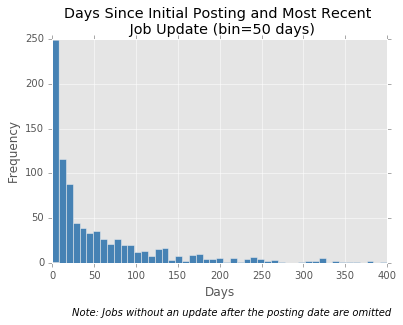

In [12]:
%matplotlib inline
import matplotlib
from pylab import figtext
import numpy as np
matplotlib.style.use('ggplot')
time_df['days_int'] = time_df['days_open'].dt.days
ax = time_df[time_df['days_int']>0]['days_int'].plot.hist(bins=np.linspace(0,400,50), 
                                                          color='steelblue', 
                                                          title='Days Since Initial Posting and Most Recent \n Job Update (bin=50 days)')
figtext(0.91, -.06, 'Note: Jobs without an update after the posting date are omitted', ha='right', style='italic')
ax.set_xlabel('Days')
_ = ax # hide text output of chart by assigning it to a variable

___
### *Top 25 Most Difficult to Fill Jobs*

In [13]:
#show dataframe of top 25 most difficult to fill positions (using index as rank)
time_df_top_25 = time_df.sort_values('days_open', ascending=False).head(25).set_index([[x for x in xrange(1,26)]])
time_df_top_25

,Job ID,Agency,# Of Positions,Business Title,Salary Frequency,salary_midpoint,Posting Date,Posting Updated,Process Date,days_open,days_int
1,124287,LAW DEPARTMENT,1,LAW STUDENT,Annual,35314.0,2013-08-01,2016-10-11,03/14/2017 00:00:00,1167 days,1167
2,156256,DEPT OF ENVIRONMENT PROTECTION,1,Fleet Services Specialist,Annual,46028.5,2014-07-21,2017-03-01,03/14/2017 00:00:00,954 days,954
3,219180,DEPARTMENT OF FINANCE,1,College Aide,Hourly,12.0,2015-10-19,2017-02-16,03/14/2017 00:00:00,486 days,486
4,222840,DEPARTMENT OF TRANSPORTATION,3,Naval Architect,Annual,99521.0,2015-11-25,2017-02-08,03/14/2017 00:00:00,441 days,441
5,227001,DEPT OF HEALTH/MENTAL HYGIENE,2,"Supervising Physician, Family and Child Health...",Hourly,73.5,2015-12-31,2017-02-02,03/14/2017 00:00:00,399 days,399
6,225597,DEPARTMENT OF CORRECTION,26,Cook,Annual,41428.0,2015-12-11,2016-12-27,03/14/2017 00:00:00,382 days,382
7,195272,DEPT OF HEALTH/MENTAL HYGIENE,1,"Supervising MD, Bureau of School Health",Hourly,68.5,2015-05-22,2016-06-03,03/14/2017 00:00:00,378 days,378
8,172546,DEPT OF HEALTH/MENTAL HYGIENE,12,"City Research Scientist, Bureau of Childcare",Annual,62493.0,2014-10-23,2015-10-22,03/14/2017 00:00:00,364 days,364
9,191646,DEPT OF PARKS & RECREATION,16,Forester,Annual,51230.0,2015-04-24,2016-04-11,03/14/2017 00:00:00,353 days,353
10,236389,HOUSING PRESERVATION & DVLPMNT,1,LL44 Transparency Manager,Annual,70000.0,2016-03-28,2017-03-09,03/14/2017 00:00:00,346 days,346


### Other Dataset Highlights
- NYC has 5643 open jobs listed
- 92.45% (5217) of jobs are externally posted.

### Method

- The midpoint of the salary range for each position is used
- Duplicate rows are removed - only first occurence of each Job ID is shown. (This removes duplicates when a job is posted both internally and externally)
- All daily and hourly positions are annualized:
  - Hourly Positions are estimated at 40 hours a week for 50 weeks
  - Daily Salaries are estimated at 5 days a week for 50 weeks
- Time between most recent job update and original posting is used as a proxy for difficulty to fill.

### Data Concerns

This dataset does not always match the career information on the agency pages raising potential concerns about it's accuracy.  Examples include:
- The Office of Management & Budget only includes one job and that one was posted in 2015, however there are dozens of more recent jobs on the [agency's career page](http://www1.nyc.gov/site/omb/careers/careers.page)
- The Department of Environmental Protection has jobs posted all the way back to 2012 in this dataset.  The oldest posting on the [agency's career page](http://www.nyc.gov/html/dep/html/job_opportunities/index_wide.shtml) at the time of writing was in November 2016.

In [14]:
#Tests
assert source_df['Process Date'][0]=='03/14/2017 00:00:00', 'The file posted on 3/14 is not being used'
assert True not in df.duplicated('Job ID'), 'The datset contains duplicate Job IDs'
assert len(df['has_external_posting'].unique()) == 2, 'There are more than 2 values for Boolean column has_external_posting'
assert len(df) <= len(source_df), 'filtered dataframe is larger than source'
assert df['annualized_salary'].isnull().values.any() == False, 'annualized salary has blank values'
assert df[df['Posting Updated']==''].values.any() == False, 'Posting Updated column has blank values'

print 'All tests pass'

All tests pass
